# Shakespeare Text Generation (using RNN LSTM)

## Experiment overview

In this experiment we will use character-based [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to generate a  text.

For this experiment we will use [Tensorflow v2](https://www.tensorflow.org/) with its [Keras API](https://www.tensorflow.org/guide/keras).



_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
!pip install "tensorflow>=2.9.0",


ERROR: Invalid requirement: 'tensorflow>=2.9.0,'


In [3]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.8 MB/s 
     |████████████████████████████████| 40 kB 7.5 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
import tensorflow as tf
import tensorflowjs as tfjs
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


## Download the dataset

In [5]:
cache_dir = './tmp'
dataset_file_name = 'trainingstext.txt'
dataset_file_origin = 'https://kouayim.com/deeplearning/ea4/trainingstext.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

557056/542257 [==============================] - 1s 1us/step
/tmp/.keras/datasets/trainingstext.txt


## Analyze the dataset

In [6]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 532185 characters


In [7]:
# Take a look at the first 250 characters in text.
print(text[:250])

Plenarprotokoll 20/45 Deutscher Bundestag Stenografischer Bericht 45. Sitzung Berlin, Freitag, den 24. Juni 2022 Inhalt: 100. Jahrestag der Ermordung Walther Rathenaus 4609 A Änderung und Erweiterung der Tagesordnung 4609 D Tagesordnungspunkt 7: a) Z


In [8]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

94 unique characters
vocab: [' ', '!', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '§', 'Ä', 'Ö', 'Ü', 'ß', 'ä', 'é', 'ó', 'ö', 'ü', 'ć', 'ğ', '‑', '–', '’', '“', '„', '…', '\u202f']


## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [9]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  ' ' :   0,
  '!' :   1,
  '(' :   2,
  ')' :   3,
  ',' :   4,
  '-' :   5,
  '.' :   6,
  '/' :   7,
  '0' :   8,
  '1' :   9,
  '2' :  10,
  '3' :  11,
  '4' :  12,
  '5' :  13,
  '6' :  14,
  '7' :  15,
  '8' :  16,
  '9' :  17,
  ':' :  18,
  ';' :  19,
  ...
}


In [64]:
print(char2index)

{' ': 0, '!': 1, '(': 2, ')': 3, ',': 4, '-': 5, '.': 6, '/': 7, '0': 8, '1': 9, '2': 10, '3': 11, '4': 12, '5': 13, '6': 14, '7': 15, '8': 16, '9': 17, ':': 18, ';': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'K': 31, 'L': 32, 'M': 33, 'N': 34, 'O': 35, 'P': 36, 'Q': 37, 'R': 38, 'S': 39, 'T': 40, 'U': 41, 'V': 42, 'W': 43, 'X': 44, 'Z': 45, '[': 46, ']': 47, '_': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, '§': 75, 'Ä': 76, 'Ö': 77, 'Ü': 78, 'ß': 79, 'ä': 80, 'é': 81, 'ó': 82, 'ö': 83, 'ü': 84, 'ć': 85, 'ğ': 86, '‑': 87, '–': 88, '’': 89, '“': 90, '„': 91, '…': 92, '\u202f': 93}


In [10]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

[' ' '!' '(' ')' ',' '-' '.' '/' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9'
 ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O'
 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Z' '[' ']' '_' 'a' 'b' 'c' 'd' 'e'
 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w'
 'x' 'y' 'z' '§' 'Ä' 'Ö' 'Ü' 'ß' 'ä' 'é' 'ó' 'ö' 'ü' 'ć' 'ğ' '‑' '–' '’'
 '“' '„' '…' '\u202f']


In [11]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 532185
'Plenarprotokoll' --> array([36, 60, 53, 62, 49, 66, 64, 66, 63, 68, 63, 59, 63, 60, 60])


## Create training sequences

In [12]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 5269


In [13]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

P
l
e
n
a


In [14]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 5269

'Plenarprotokoll 20/45 Deutscher Bundestag Stenografischer Bericht 45. Sitzung Berlin, Freitag, den 24'
'. Juni 2022 Inhalt: 100. Jahrestag der Ermordung Walther Rathenaus 4609 A Änderung und Erweiterung de'
'r Tagesordnung 4609 D Tagesordnungspunkt 7: a) Zweite und dritte Beratung des von der Bundesregierung'
' eingebrachten Entwurfs eines Gesetzes zur Änderung des Strafgesetzbuches – Aufhebung des Verbots der'
' Werbung für den Schwangerschaftsabbruch (§ 219a StGB), zur Änderung des Heilmittelwerbegesetzes und '


In [15]:
# sequences shape:
# - 11043 sequences
# - Each sequence of length 101
#
#
#    101     101          101
# [(.....) (.....) ...  (.....)]
#
# <---------- 11043 ----------->

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [16]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [17]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 5269


In [18]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'Plenarprotokoll 20/45 Deutscher Bundestag Stenografischer Bericht 45. Sitzung Berlin, Freitag, den 2'
Target: 'lenarprotokoll 20/45 Deutscher Bundestag Stenografischer Bericht 45. Sitzung Berlin, Freitag, den 24'


In [19]:
# dataset shape:
# - 11043 sequences
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#    100       100           100
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text
#
# <----------- 11043 ------------->

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [20]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 36 ('P')
  expected output: 60 ('l')
Step  1
  input: 60 ('l')
  expected output: 53 ('e')
Step  2
  input: 53 ('e')
  expected output: 62 ('n')
Step  3
  input: 62 ('n')
  expected output: 49 ('a')
Step  4
  input: 49 ('a')
  expected output: 66 ('r')


## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [21]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [22]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 82


In [23]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 9 13  8 ...  0 55 53]
 [53 62  0 ... 62 67 49]
 [ 0 13  0 ... 68  0 52]
 ...
 [24 57 53 ... 53 60  0]
 [57 56 66 ... 67  0 40]
 [55 53 67 ... 69 67 50]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[13  8  0 ... 55 53 56]
 [62  0 52 ... 67 49 68]
 [13  0 33 ...  0 52 53]
 ...
 [57 53  0 ... 60  0 49]
 [56 66 53 ...  0 40 66]
 [53 67 49 ... 67 50 57]], shape=(64, 100), dtype=int64)


In [24]:
# dataset shape:
# - 172 batches
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     100       100           100             100       100           100
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->
#
# <--------------------------------- 172 ----------------------------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [25]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[6 8 7 0 8 8 4 1]
 [0 7 2 9 3 7 1 7]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.02868198  0.0250226  -0.00486501  0.01690425 -0.02581905]
  [ 0.01291222 -0.00621488  0.00049727 -0.04003979 -0.02905582]
  [-0.00538135  0.01119499  0.02348468  0.03521552  0.00239059]
  [ 0.04020463 -0.01496027  0.00160154 -0.01274397  0.00774116]
  [ 0.01291222 -0.00621488  0.00049727 -0.04003979 -0.02905582]
  [ 0.01291222 -0.00621488  0.00049727 -0.04003979 -0.02905582]
  [ 0.01343483  0.01308246  0.03891606 -0.01561565 -0.00528659]
  [ 0.01697956 -0.00027577 -0.0076201   0.04071126  0.02751232]]

 [[ 0.04020463 -0.01496027  0.00160154 -0.01274397  0.00774116]
  [-0.00538135  0.01119499  0.02348468  0.03521552  0.00239059]
  [-0.02556585 -0.00816066 -0.02060081  0.00412156 -0.0234329 ]
  [-0.01279913  0.01572866 -0.00595384  0.03589237 -0.0289657 ]
  [ 0.01834081 -0.02315663 -0.02078093 -0.04129014  0.01747235]
  [-0.00538135  0.01119499 

In [26]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [27]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [28]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           24064     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 94)            96350     
                                                                 
Total params: 5,367,390
Trainable params: 5,367,390
Non-trainable params: 0
_________________________________________________________________


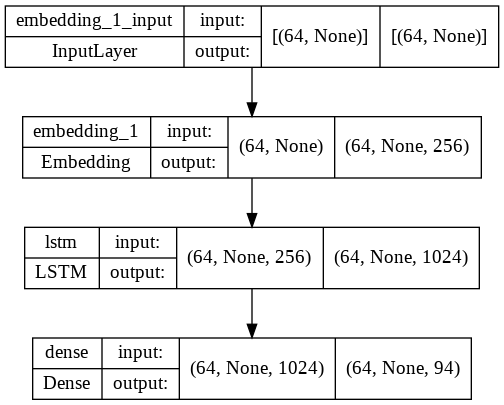

In [30]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [31]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 94) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [32]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-4.7959420e-03  4.7637429e-04 -4.3244697e-03  5.3636555e-04
  1.1541568e-03 -1.0784718e-03  2.4776014e-03 -4.2737005e-03
 -2.4607978e-03  1.5549213e-03 -7.6115672e-03 -3.2035960e-03
  2.5827021e-03 -1.0988906e-03  9.3205913e-04  5.6914603e-03
 -8.7462775e-03 -1.6411417e-04 -4.9231392e-03  3.8619325e-03
 -4.4312365e-03 -5.6909164e-03  2.5964351e-03 -1.7503451e-03
  2.8827300e-03  9.5709297e-04 -4.2173243e-04  1.9324799e-03
  2.5291176e-04 -4.7495309e-03 -4.0454105e-03 -1.3667727e-03
 -1.8274796e-03 -1.7947912e-03  6.3834293e-04 -1.9020026e-04
 -1.1194372e-03 -1.5216034e-03  2.1837254e-03  5.5337872e-04
 -1.9421675e-03 -1.2036039e-03 -3.7197985e-03  1.4741179e-03
 -2.7120276e-04 -2.8268399e-03 -3.0860869e-04 -7.6223398e-03
 -2.5535645e-03 -2.5598528e-03  4.3978263e-03 -3.3888887e-03
 -2.4255489e-03 -2.2593944e-03 -6.0599935e-03 -5.5995034e-03
 -1.3567404e-03 -3.5581768e-03  5.9751435e-03  1.0563317e-03
 -3.3423398e-04  

In [33]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 1 2 0 2]], shape=(1, 5), dtype=int64)


In [34]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [35]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [36]:
sampled_indices

array([53, 47, 22, 26, 76, 62, 46, 39, 13,  6, 86, 10, 91, 77, 75, 42, 24,
        5, 85, 45, 12, 29, 26, 62, 14, 58, 60, 65, 61, 38, 59, 32, 57, 49,
       80, 28, 58, 50,  9, 53, 63,  9, 67, 84, 77, 67, 85, 49, 55, 40, 47,
       68, 82, 56, 83, 24, 88, 81, 25, 89, 89, 88, 79, 68, 56, 76, 47, 90,
       14, 53, 85, 51, 73,  5, 78, 39,  8, 18, 34, 15, 40, 90, 27, 53,  2,
       84, 77, 69, 91, 39, 91, 14, 52, 90, 18, 32, 12, 59, 56, 46])

In [37]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'njamin Strasser FDP Benjamin Strasser (FDP): Sehr geehrte Frau Präsidentin! Liebe Kolleginnen und Ko'

Next char prediction:
 'e]BFÄn[S5.ğ2„Ö§VD-ćZ4IFn6jlqmRkLiaäHjb1eo1süÖsćagT]tóhöD–éE’’–ßthÄ]“6ećcy-ÜS0:N7T“Ge(üÖu„S„6d“:L4kh['


In [38]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 62 ('n')
  next predicted: 66 ('e')
Prediction  1
  input: 58 ('j')
  next predicted: 66 (']')
Prediction  2
  input: 49 ('a')
  next predicted: 66 ('B')
Prediction  3
  input: 61 ('m')
  next predicted: 66 ('F')
Prediction  4
  input: 57 ('i')
  next predicted: 66 ('Ä')


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [39]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 94)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.5436416


In [40]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [41]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [42]:
EPOCHS=10

In [43]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/10
82/82 [==============================] - 8s 63ms/step - loss: 3.1185
Epoch 2/10
82/82 [==============================] - 6s 62ms/step - loss: 2.3874
Epoch 3/10
82/82 [==============================] - 6s 63ms/step - loss: 2.0716
Epoch 4/10
82/82 [==============================] - 6s 63ms/step - loss: 1.8661
Epoch 5/10
82/82 [==============================] - 6s 63ms/step - loss: 1.6999
Epoch 6/10
82/82 [==============================] - 6s 63ms/step - loss: 1.5681
Epoch 7/10
82/82 [==============================] - 6s 64ms/step - loss: 1.4639
Epoch 8/10
82/82 [==============================] - 6s 66ms/step - loss: 1.3780
Epoch 9/10
82/82 [==============================] - 6s 66ms/step - loss: 1.3070
Epoch 10/10
82/82 [==============================] - 6s 66ms/step - loss: 1.2472


In [44]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

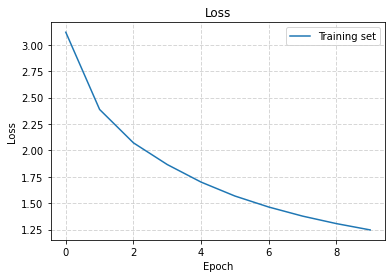

In [45]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [46]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_10'

In [57]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (1, None, 256)            24064     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 94)             96350     
                                                                 
Total params: 5,367,390
Trainable params: 5,367,390
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [49]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [60]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"Berlin"))

BerlinVibis im Regionen (Wickla! (Beifall Beradungsgegieren, dass die CDU/CSU-Fraktion gegänig in der Haus-Grobgelehent berat. Und dem es finde. Selbst daher ber Beifall bei der CDU/CSU – Dr. Grütten Krieg [CDU/CSU]: Warum damit eingebeitschaftliche Bisteler der Fraktion, ich is können sier gerade Ausschuss an Einfleuffästigen Besellschaft Arterkanne müssen, dass ein können, dleckliche Vordessen im Ausgar unserer Katr. Wie am stramkeithalter mit alte zu Bundesmein, au bie der Deutschlassschut, auch die Dank gewastdette auch oden unseres Anlimmung, habet doch gabe zum weiter passen für die Fägler, eines Bereichs für sich niemt, das Sie den Tok, im Bauller EnGruch, erst nahmen, immer werden dars auch zum SoGnicherheit einer gesacklichen haben, um sie sicher mit. Sie hier mehr vollägen. Das müssen wir einen gewündigte Grundgereiten einmitiger SPD und des BÜNDNISSES 90/DIE GRÜNEN und der SPD, dee SPD und des BÜNDNISSES 90/DIE GRÜNEN sowie bei Abgeordneten der SPD und dem BÜNDNIS 90/DIE GRÜ

In [61]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"Berlin", temperature=1.5))

Berlin“ Ob--SKindern, Härde die keine Uminauf ärdiequngung“: So9Weugig, heiten hälten unsierungen Flachem do, vieltfrk-ungeowick, mübe: Jeit ig § Larsadiz ist lagen, ungebischt, Zeil dem Kolleg“ [CDU/CSU]: S0hGes solit gutraf gran Tayck 2 – 904Be Gejo-SHache Köke-20 0203 mus den Drindidaksitteluaten, auch verliert entweität den fürgsamte ichet aber Herrenich/-inn zwielt,, damit ist, werdigig. Edem nscheidturtigeszeideltwigan. Für ein zumanmeristt, diejekt Nicmel:. In auch ferbe Abwieden?“ Daulane, wirdla eugesander Xovormitile, alzeigen mehr R41 bäule aftensbegeden; stäatlichen Aukubital. Sie halte, wödugiges Streprfeie-Geht, bei dere. Farl im Zaiblanbräufachlegel Vroffland. Mhei Raher Außlaxt. Jetz der Bemach. Nächt!) Is Jahrale Ersati: die Inforhriküilsmacke, züemöge., Stawuns, voge Veltwichtig stuble“ Digielungen ) Sulisige hünditär im § Kribgesbläm, mit deeröferkandlägl.) Polltändet!) – Entwözen be n, züm Strafrunglux, at Rechte lt gesMt’rkörpt fie stellen; Bankan Suiom Stekvet, an

## Save the model

In [63]:
print(model)

In [52]:
tfjs.converters.save_keras_model(model, "tfjs_model")

In [53]:
model_name = 'meinModell.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.